In [2]:
# 📌 1. Import Libraries
# ========================
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.api import VAR

In [4]:
print(np.__version__)


1.24.3


In [ ]:
# 📂 2. Load Dataset
# ========================
DATA_PATH = os.path.join("../Dataset/GHG_cleaned_v1.csv")
GHG_DATA = pd.read_csv(DATA_PATH)
print("🔹 Columns:", GHG_DATA.columns)

🔹 Columns: Index(['Date', 'GHG', 'CH4', 'CO2', 'F-Gas', 'N2O'], dtype='object')


In [ ]:
# 🧹 3. Data Cleaning & Overview
# ========================
# ตรวจสอบ Missing และ Duplicate
print("\n🔍 Missing values:\n", GHG_DATA.isnull().sum())
print("🔍 Duplicate rows:", GHG_DATA.duplicated().sum())
print("\n📊 Descriptive Stats:\n", GHG_DATA.describe())


🔍 Missing values:
 Date     0
GHG      0
CH4      0
CO2      0
F-Gas    0
N2O      0
dtype: int64
🔍 Duplicate rows: 0

📊 Descriptive Stats:
               Date         GHG        CH4         CO2      F-Gas        N2O
count    32.000000   32.000000  32.000000   32.000000  32.000000  32.000000
mean   2005.500000  314.643750  74.559062  202.264687  17.885000  19.935000
std       9.380832   84.870165   9.718977   55.708404  22.043362   2.830443
min    1990.000000  172.460000  57.030000   99.650000   0.270000  15.510000
25%    1997.750000  257.152500  66.822500  166.337500   3.292500  17.390000
50%    2005.500000  292.900000  76.890000  190.905000   7.435000  20.040000
75%    2013.250000  396.197500  82.177500  262.515000  24.167500  22.670000
max    2021.000000  451.850000  88.960000  287.210000  76.460000  24.370000


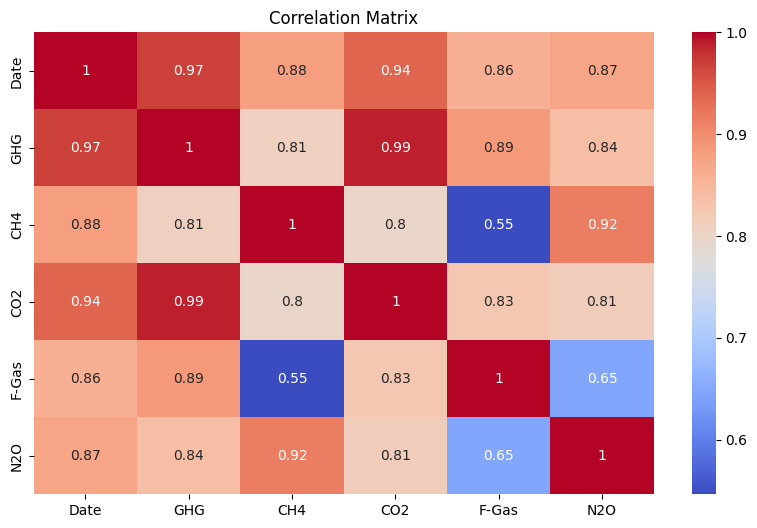

In [ ]:
# 🔗 4. Correlation Analysis
# ========================
plt.figure(figsize=(10, 6))
sns.heatmap(GHG_DATA.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

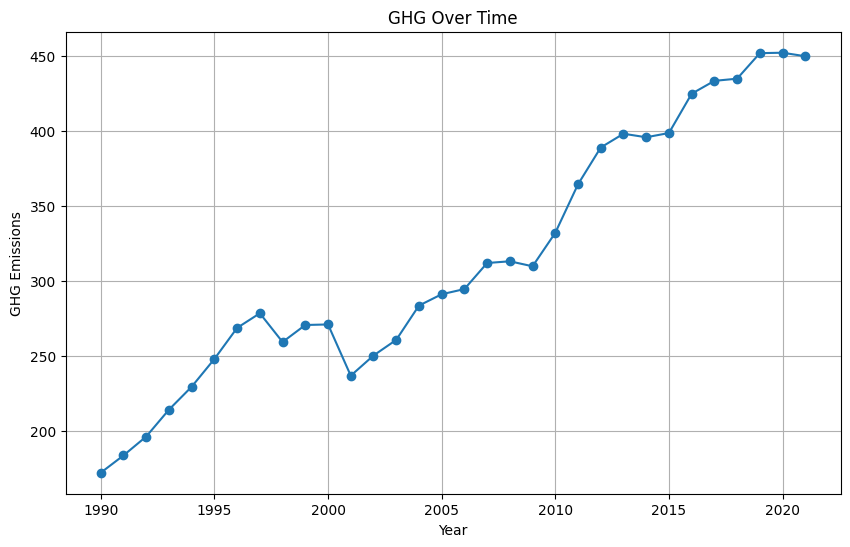

In [ ]:
# 📈 5. Trend Analysis แนวโน้ม (Trend) ของ GHG
# ========================
plt.figure(figsize=(10, 6))
plt.plot(GHG_DATA["Date"], GHG_DATA["GHG"], marker='o')
plt.title("GHG Over Time")
plt.xlabel("Year")
plt.ylabel("GHG Emissions")
plt.grid(True)
plt.show()

In [ ]:
# ⏳ 6. Time Series Preparation & Stationarity
# ========================
df_ts = GHG_DATA.copy()
df_ts["Date"] = pd.to_datetime(df_ts["Date"], format='%Y')
df_ts.set_index("Date", inplace=True)

In [ ]:
# 🧪  6.1 ADF Test - Stationarity Check
# ถ้า p-value < 0.05 → ข้อมูล stationary พร้อมพยากรณ์
# ถ้า p-value > 0.05 → ต้องทำ differencing ก่อน
adf_result = adfuller(df_ts["GHG"])
print("\n🔍 ADF Test (Before Differencing)")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")


🔍 ADF Test (Before Differencing)
ADF Statistic: -0.6100410088600948
p-value: 0.86869699032517



🔁 ADF Test (After Differencing)
ADF Statistic: -4.494314132612776
p-value: 0.00020134439147941882


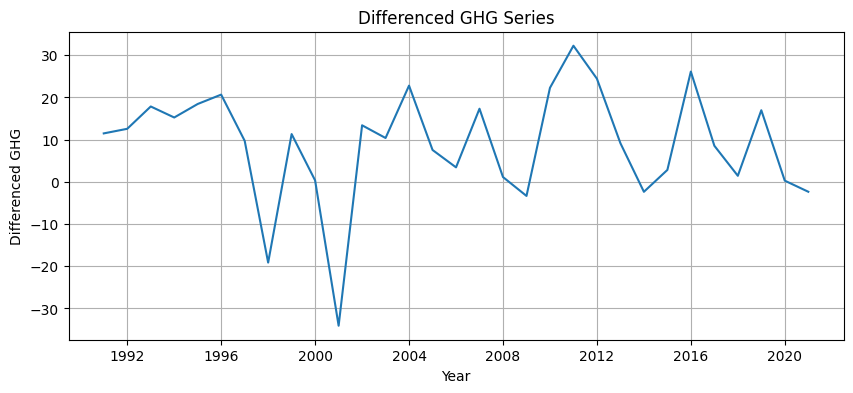

In [ ]:
# 🔁 6.2 Differencing (if non-stationary)
df_ts["GHG_diff"] = df_ts["GHG"].diff()
adf_diff = adfuller(df_ts["GHG_diff"].dropna())

# 🔍 ตรวจสอบอีกครั้งหลังทำ differencing
print("\n🔁 ADF Test (After Differencing)")
print(f"ADF Statistic: {adf_diff[0]}")
print(f"p-value: {adf_diff[1]}")

# Plot Differenced Series
plt.figure(figsize=(10, 4))
plt.plot(df_ts["GHG_diff"])
plt.title("Differenced GHG Series")
plt.xlabel("Year")
plt.ylabel("Differenced GHG")
plt.grid(True)
plt.show()

In [ ]:
# ⚙️ 7. ARIMA Modeling & Forecasting

In [ ]:
# 📌 7.1 Fit ARIMA Model
# หา p, d, q ที่เหมาะสมด้วย Auto ARIMA
stepwise_fit = auto_arima(df_ts["GHG"], start_p=0, start_q=0,
                          max_p=5, max_q=5, d=1,
                          seasonal=False, trace=True,
                          suppress_warnings=True, stepwise=True)

print("\n📋 ARIMA Model Summary")
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=251.726, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=253.060, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=252.618, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=261.493, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=251.891, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.097 seconds

📋 ARIMA Model Summary
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -123.863
Date:                Sun, 13 Apr 2025   AIC                            251.726
Time:                        22:43:30   BIC                            254.594
Sample:                    01-01-1990   HQIC                           252.661
                         - 01-01-2021                     

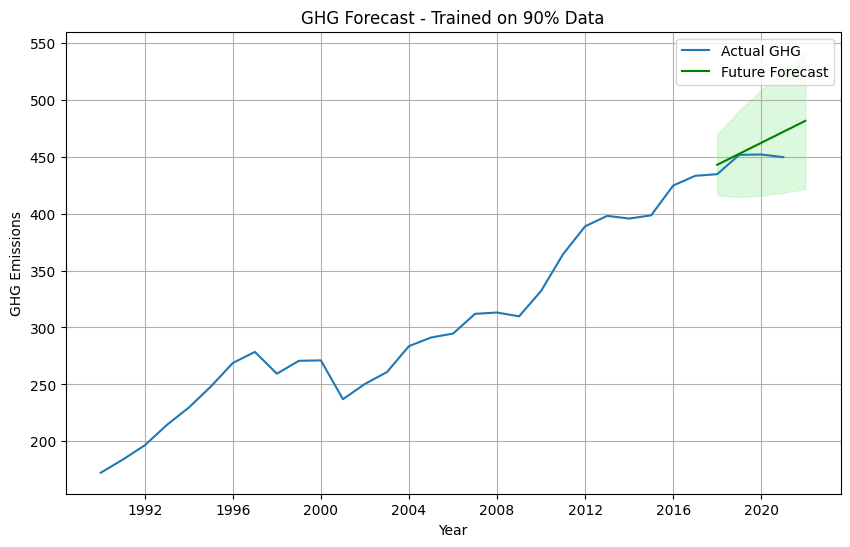

In [ ]:
# 🔮 7.2 Forecast Future (5 Years Ahead)
# ✂️ Train on 90% for future forecast
train_size = int(len(df_ts) * 0.9)
train_future = df_ts["GHG"][:train_size]
test_future_dates = pd.date_range(start=df_ts.index[train_size], periods=5, freq='YS')

# 🔁 Fit + Forecast
model_future = auto_arima(train_future, d=1, seasonal=False, suppress_warnings=True)
future_forecast, conf_int = model_future.predict(n_periods=5, return_conf_int=True)

# 📄 Forecast DataFrame
future_df = pd.DataFrame({
    "Forecast": future_forecast,
    "Lower CI": conf_int[:, 0],
    "Upper CI": conf_int[:, 1]
}, index=test_future_dates)

# Plot Forecast
plt.figure(figsize=(10, 6))
plt.plot(df_ts["GHG"], label="Actual GHG")
plt.plot(future_df["Forecast"], label="Future Forecast", color='green')
plt.fill_between(future_df.index, future_df["Lower CI"], future_df["Upper CI"], alpha=0.3, color='lightgreen')
plt.title("GHG Forecast - Trained on 90% Data")
plt.xlabel("Year")
plt.ylabel("GHG Emissions")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 📏 8. ประเมินผล ARIMA Model Evaluation (80/20 Split)
# ========================
# Split 80/20
train_size = int(len(df_ts) * 0.8)
train, test = df_ts["GHG"][:train_size], df_ts["GHG"][train_size:]

# ฟิตโมเดลใหม่กับ train
model = auto_arima(train, d=1, seasonal=False, suppress_warnings=True)
preds = model.predict(n_periods=len(test))

# Evaluation Metrics
mse = mean_squared_error(test, preds)
mae = mean_absolute_error(test, preds)
r2 = r2_score(test, preds)

print("\n📊 Evaluation Metrics")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")


📊 Evaluation Metrics
MSE: 65.76
MAE: 7.05
R²: 0.79


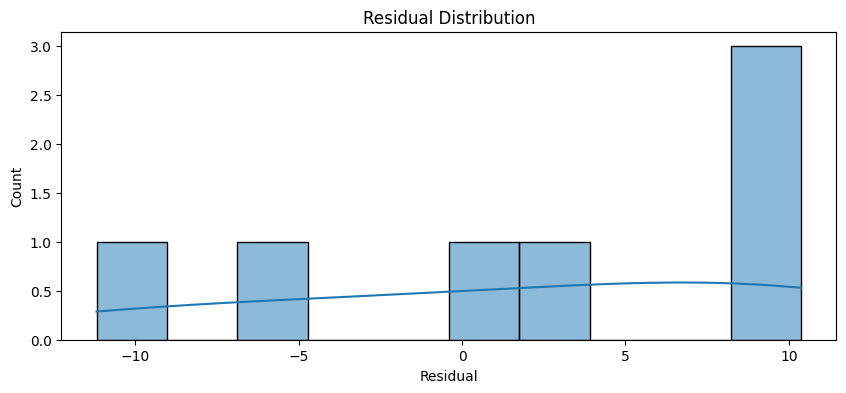

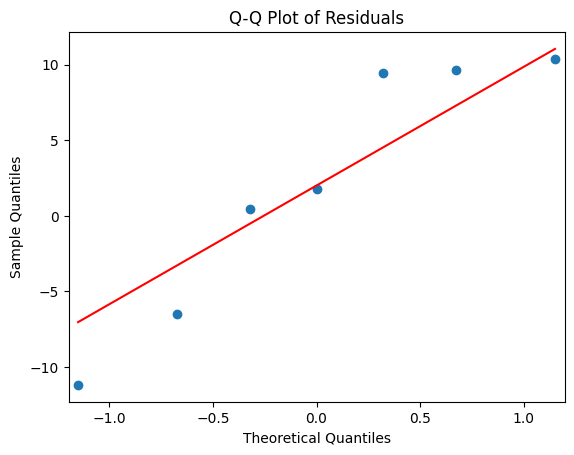

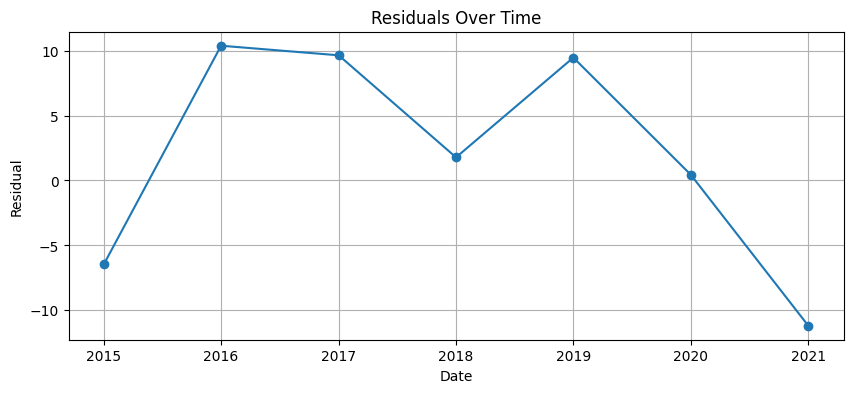

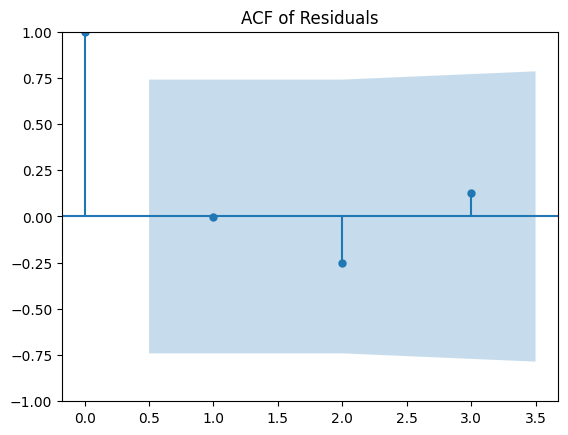

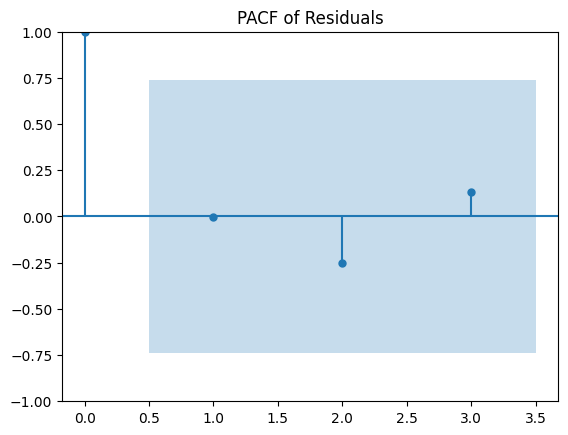


🧪 Ljung-Box Test:
     lb_stat  lb_pvalue
6  10.370583   0.109889


In [ ]:
# 📉 9. Residuals Analysis
# ========================
residuals = test - preds

# Histogram
plt.figure(figsize=(10, 4))
sns.histplot(residuals, bins=10, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.show()

# Q-Q Plot
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()

# Residuals Over Time
plt.figure(figsize=(10, 4))
plt.plot(residuals, marker='o')
plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.grid(True)
plt.show()

# ACF/PACF
plot_acf(residuals.dropna())
plt.title("ACF of Residuals")
plt.show()

plot_pacf(residuals.dropna())
plt.title("PACF of Residuals")
plt.show()

# Ljung-Box Testอ
# เช็คว่ามี residuals กี่ตัว แล้วใช้ lags ต่ำกว่า
# Ljung-Box: p-value > 0.05 → residual คล้าย white noise → โมเดลดี
max_lags = min(10, len(residuals.dropna()) - 1)
lb_test = acorr_ljungbox(residuals.dropna(), lags=[max_lags], return_df=True)
print("\n🧪 Ljung-Box Test:")
print(lb_test)

In [ ]:
# 📋 10. Compare Actual vs Predicted
# ========================
# ลองแสดงตารางสรุปผลพยากรณ์กับค่าจริง
results_df = pd.DataFrame({
    "Actual": test.values,
    "Predicted": preds
}, index=test.index)

print("\n📋 Compare Actual vs Predicted")
print(results_df.head())


📋 Compare Actual vs Predicted
            Actual   Predicted
Date                          
2015-01-01  398.44  404.907917
2016-01-01  424.58  414.205833
2017-01-01  433.14  423.503750
2018-01-01  434.58  432.801667
2019-01-01  451.56  442.099583


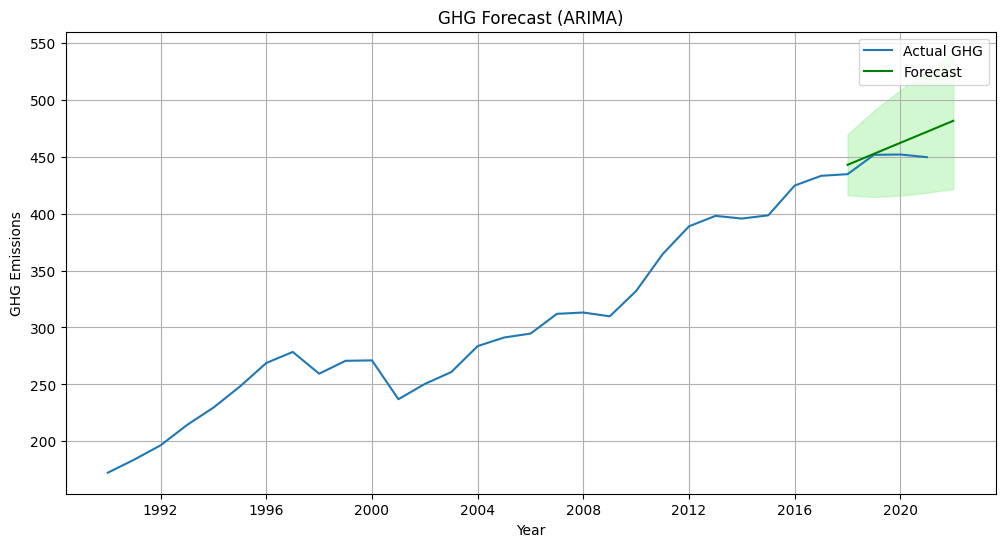

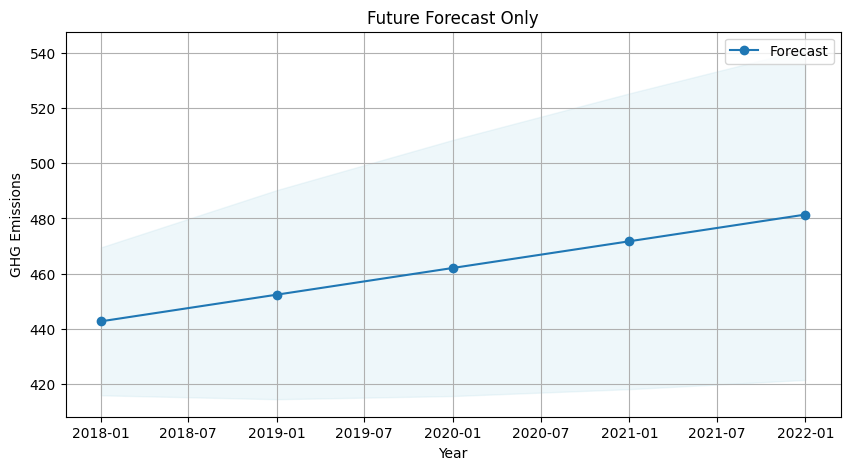

In [ ]:
# 📈 11. Visualize All Forecasts
# ========================
# All Forecast Overview
plt.figure(figsize=(12, 6))
plt.plot(df_ts["GHG"], label="Actual GHG")
plt.plot(future_df["Forecast"], label="Forecast", color='green')
plt.fill_between(future_df.index, future_df["Lower CI"], future_df["Upper CI"], alpha=0.4, color='lightgreen')
plt.title("GHG Forecast (ARIMA)")
plt.xlabel("Year")
plt.ylabel("GHG Emissions")
plt.legend()
plt.grid(True)
plt.show()

# Future Forecast Only
plt.figure(figsize=(10, 5))
plt.plot(future_df["Forecast"], marker='o', label="Forecast")
plt.fill_between(future_df.index, future_df["Lower CI"], future_df["Upper CI"], alpha=0.2, color='lightblue')
plt.title("Future Forecast Only")
plt.xlabel("Year")
plt.ylabel("GHG Emissions")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 📌 12. Report Summary
# ========================
print("\n📝 Summary for Report:")
trend = 'ลดลง' if df_ts['GHG'].iloc[-1] < df_ts['GHG'].iloc[0] else 'เพิ่มขึ้น'
print(f"• GHG emissions แสดงแนวโน้ม {trend} ในช่วงปี {df_ts.index.year.min()} - {df_ts.index.year.max()}")
print("• จากโมเดล ARIMA พบว่า residual ไม่มีรูปแบบเฉพาะ (randomness สูง) → โมเดลเหมาะสม")
print(f"• ค่า R² = {r2:.2f} บ่งบอกว่าโมเดลสามารถอธิบายความแปรปรวนของข้อมูลได้ {'มาก' if r2 > 0.8 else 'พอสมควร'}")

interval_width = np.mean(future_df["Upper CI"] - future_df["Lower CI"])
print(f"• ความกว้างเฉลี่ยของช่วงพยากรณ์: {interval_width:.2f}")


📝 Summary for Report:
• GHG emissions แสดงแนวโน้ม เพิ่มขึ้น ในช่วงปี 1990 - 2021
• จากโมเดล ARIMA พบว่า residual ไม่มีรูปแบบเฉพาะ (randomness สูง) → โมเดลเหมาะสม
• ค่า R² = 0.79 บ่งบอกว่าโมเดลสามารถอธิบายความแปรปรวนของข้อมูลได้ พอสมควร
• ความกว้างเฉลี่ยของช่วงพยากรณ์: 89.66


In [ ]:
# 🧪 14. Overfitting Check
# ========================
# หาก Train R² >> Test R² มาก → อาจมี overfitting
train_preds = model.predict_in_sample()
train_mse = mean_squared_error(train, train_preds)
train_r2 = r2_score(train, train_preds)
print(f"\n🧪 Train MSE: {train_mse:.2f}")
print(f"🧪 Train R²: {train_r2:.2f}")


🧪 Train MSE: 1253.02
🧪 Train R²: 0.66
